In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold, datasets
import gym
from copy import deepcopy
from scipy import stats
import os
import torch
import os.path as osp

In [4]:
def print_2f(*args):
    __builtins__.print(*("%.2f" % a if isinstance(a, float) else a
                         for a in args))

def get_action(o, md, deterministic=True):
    o = torch.as_tensor(o, dtype=torch.float32)
    a = md.act(o)
    return a

def test_model(env, model, max_ep_len=None, num_episodes=20, interval = 1):
    o, r, d, ep_ret, ep_len, n = env.reset(), 0, False, 0, 0, 0
    total_rewards = []
    trajs = []
    mid_points = {}
    while n < num_episodes:
        if ep_len % interval == 0:
            old_state = save_state(env)
            mid_points[ep_len] = old_state
        a = get_action(o, model)
        o, r, d, _ = env.step(a)
        ep_ret += r
        ep_len += 1
        if d or (ep_len == max_ep_len):
            total_rewards.append(ep_ret)
            trajs.append(mid_points)
            mid_points = {}
            o, r, d, ep_ret, ep_len = env.reset(), 0, False, 0, 0
            n += 1
    return total_rewards, trajs

def get_good_trajs(env, model, num, max_ep_len=1000):
    total_rewards = []
    trajs = []
    while len(total_rewards) < num:
        r, t = test_model(env, model, max_ep_len, num - len(total_rewards))
        thr = vmean(r)
        for i in range(len(r)):
            if r[i] > thr-1 and len(t[i])>=800:
                total_rewards.append(r[i])
                trajs.append(t[i])
    return total_rewards, trajs


def get_models(path, env_name, name):
    env = gym.make(env_name)
    fpath = osp.join(path, name)
    print(fpath)
    models = []
    while 1:
        if 'ppo' in name:
            fname = osp.join(fpath, name + "_" + str(len(models)) + '.pt')
        else:
            fname = osp.join(fpath, name + "_s" + str(len(models)) ,'pyt_save', 'model.pt')
        print(fname)
        if(osp.exists(fname)):
            if 'ppo' in fname:
                env = gym.make(env_name)
                obs_dim = env.observation_space.shape[0]
                action_dim = env.action_space.shape[0]
                model = PPO_Actor(obs_dim, action_dim, (64, 64), nn.Tanh)
                model.load(fname)
                models.append(model)
            else:
                model = torch.load(fname)
                models.append(model)
        else:
            break
    # print(len(models))
    test_val = []
    for model in models:
        x, _ = test_model(env, model, num_episodes=20)
        # print(x, stats.trim_mean(x, 0.1))
        test_val.append(stats.trim_mean(x, 0.1))
    print_2f(test_val)
    sorted_ids = np.argsort(test_val)
    model1 = models[sorted_ids[-1]]
    model2 = models[sorted_ids[-2]]
    return model1, model2

def run_extra_steps(env, o, ep_len, md, max_ep_len, step_num = 50):
    # return 0
    # print(env.done)
    total_r = 0
    for i in range(step_num):
        a = get_action(o, md)
        o, r, d, _ = env.step(a)
        total_r += r
        ep_len += 1
        if d or (ep_len == max_ep_len):
            # print(i, d, r, ep_len, max_ep_len)
            return (d, total_r)
    return (d, total_r)


def save_state(env):
    return env.sim.get_state()

def restore_state(env, old_state):
    env.reset()
    env.sim.set_state(old_state)
    env.sim.forward()
    return env.get_obs()

def vmean(v):
    return sum(v) / len(v)

def print_vpercent(v, sp = [1, 2.5, 5, 10, 15, 20, 30, 40, 50, 60, 70, 75, 80, 90, 99]):
    l = len(v)
    print_2f(*sp)
    vs = [v[int(l*x/100)] for x in sp]
    print_2f(*vs)
    

In [5]:
import torch.nn as nn
def plot(X_tsne, y):
    x_min, x_max = X_tsne.min(0), X_tsne.max(0)
    X_norm = (X_tsne-x_min) / (x_max-x_min)
    plt.figure(figsize=(16,16))
    for i in range(X_norm.shape[0]):
        plt.scatter(X_norm[i, 0], X_norm[i, 1], color=plt.cm.Set1(y[i]))
    plt.show()

def mlp(sizes, activation, output_activation=nn.Identity):
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)

class PPO_Actor():
    def __init__(self, obs_dim, act_dim, hidden_sizes, activation):
        self.pi = mlp([obs_dim] + list(hidden_sizes) + [act_dim], activation)
        self.obs_mean = np.ones(obs_dim)
        self.obs_std = np.ones(obs_dim)
        self.clip = 10.0
        print(type(self.pi))
    
    def normalize_o(self, o):
        o = o - self.obs_mean
        o = o / (self.obs_std + 1e-8)
        o = np.clip(o, -self.clip, self.clip)
        return o
    
    def act(self, o):
        if torch.is_tensor(o):
            o = o.numpy()
        o = self.normalize_o(o)
        o = torch.as_tensor(o, dtype=torch.float32)
        return self.pi(o).detach().numpy()
    
    def copy_model(self, md):
        self.pi.load_state_dict(md['pi'])
        self.obs_mean = md['obs_mean']
        self.obs_std = md['obs_std']
        self.clip = md['clip'] 
        
    def load(self, name):
        md = torch.load(name)
        self.copy_model(md)
        

In [6]:
sac1, sac2 = get_models('/home/lclan/spinningup/data/', 'Ant-v3', 'Ant-v3_sac_base')
td31, td32 = get_models('/home/lclan/spinningup/data/', 'Ant-v3', 'Ant-v3_td3_base')
ppo1, ppo2 = get_models('/home/lclan/spinningup/data/', 'Ant-v3', 'vanilla_ppo_ant')
env = gym.make('Ant-v3')
_, sac_t1 = test_model(env, sac1, 1000, 50)
_, sac_t2 = test_model(env, sac2, 1000, 50)
_, td3_t1 = test_model(env, td31, 1000, 50)
_, td3_t2 = test_model(env, td32, 1000, 50)
_, ppo_t1 = test_model(env, ppo1, 1000, 50)
_, ppo_t2 = test_model(env, ppo2, 1000, 50)

/home/lclan/anaconda3/envs/rob_sac/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


/home/lclan/spinningup/data/Ant-v3_sac_base
/home/lclan/spinningup/data/Ant-v3_sac_base/Ant-v3_sac_base_s0/pyt_save/model.pt
/home/lclan/spinningup/data/Ant-v3_sac_base/Ant-v3_sac_base_s1/pyt_save/model.pt
/home/lclan/spinningup/data/Ant-v3_sac_base/Ant-v3_sac_base_s2/pyt_save/model.pt
/home/lclan/spinningup/data/Ant-v3_sac_base/Ant-v3_sac_base_s3/pyt_save/model.pt
/home/lclan/spinningup/data/Ant-v3_sac_base/Ant-v3_sac_base_s4/pyt_save/model.pt
[3756.7443206333865, 4937.715621708458, 6718.0834103740235, 6062.329719329806]
/home/lclan/spinningup/data/Ant-v3_td3_base
/home/lclan/spinningup/data/Ant-v3_td3_base/Ant-v3_td3_base_s0/pyt_save/model.pt
/home/lclan/spinningup/data/Ant-v3_td3_base/Ant-v3_td3_base_s1/pyt_save/model.pt
/home/lclan/spinningup/data/Ant-v3_td3_base/Ant-v3_td3_base_s2/pyt_save/model.pt
/home/lclan/spinningup/data/Ant-v3_td3_base/Ant-v3_td3_base_s3/pyt_save/model.pt
/home/lclan/spinningup/data/Ant-v3_td3_base/Ant-v3_td3_base_s4/pyt_save/model.pt
[5820.46593118264, 5935

In [ ]:
env = gym.make('Ant-v3')
r1, t1 = test_model(env, m1, 1000, 50)
r2, t2 = test_model(env, m2, 1000, 50)

/home/lclan/anaconda3/envs/rob_sac/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [19]:
print(np.concatenate((t1[10][100].qpos, t1[10][100].qvel), axis=None))

[ 2.66393601e+01 -6.40179032e+00  5.12258692e-01  9.48295588e-01
  5.41141056e-03 -1.09786652e-01  2.97746680e-01 -4.78197689e-01
  5.21023672e-01 -5.26166850e-01 -5.16479879e-01  3.36597944e-01
 -5.20532540e-01 -5.24026609e-01  6.46805466e-01  5.98862567e+00
 -6.76750407e-02  8.39921224e-02  1.71117117e+00  6.30015859e-01
  5.60671719e-01 -8.44801993e+00  3.17763530e-02 -1.53865753e-01
 -1.82945445e-01  6.24256269e+00 -9.61949310e-02  5.41645486e-03
 -2.56981080e+00]


In [21]:
x = np.array([1,2,3])
y = np.array([1,2,4])
print(x.shape)

(3,)


In [22]:
def get_data(ts):
    ret = []
    for t in ts:
        for i in range(100, 200):
            if len(t) > i:
                ret.append(np.concatenate((t[i].qpos, t[i].qvel), axis=None))
    return ret

d1 = get_data(t1)
d2 = get_data(t2)
    

In [23]:
x = d1 + d2
y = [0]*len(d1) + [1]*len(d2)

In [28]:
x = np.array(x)
y = np.array(y)
print(x.shape, y.shape)

(10000, 29) (10000,)


In [29]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(x)

In [4]:
def plot(X_tsne, y):
    x_min, x_max = X_tsne.min(0), X_tsne.max(0)
    X_norm = (X_tsne-x_min) / (x_max-x_min)
    plt.figure(figsize=(16,16))
    for i in range(X_norm.shape[0]):
        plt.scatter(X_norm[i, 0], X_norm[i, 1], color=plt.cm.Set1(y[i]))
    plt.show()

In [5]:
sac1, sac2 = get_models('/home/lclan/spinningup/data/', 'Ant-v3', 'Ant-v3_sac_base')
td31, td32 = get_models('/home/lclan/spinningup/data/', 'Ant-v3', 'Ant-v3_td3_base')

/home/lclan/anaconda3/envs/rob_sac/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


/home/lclan/spinningup/data/Ant-v3_sac_base
/home/lclan/spinningup/data/Ant-v3_sac_base/Ant-v3_sac_base_s0/pyt_save/model.pt
/home/lclan/spinningup/data/Ant-v3_sac_base/Ant-v3_sac_base_s1/pyt_save/model.pt
/home/lclan/spinningup/data/Ant-v3_sac_base/Ant-v3_sac_base_s2/pyt_save/model.pt
/home/lclan/spinningup/data/Ant-v3_sac_base/Ant-v3_sac_base_s3/pyt_save/model.pt
/home/lclan/spinningup/data/Ant-v3_sac_base/Ant-v3_sac_base_s4/pyt_save/model.pt
[3623.5047420618675, 5549.827008836396, 6704.322321322346, 6023.883820158008]
/home/lclan/spinningup/data/Ant-v3_td3_base
/home/lclan/spinningup/data/Ant-v3_td3_base/Ant-v3_td3_base_s0/pyt_save/model.pt
/home/lclan/spinningup/data/Ant-v3_td3_base/Ant-v3_td3_base_s1/pyt_save/model.pt
/home/lclan/spinningup/data/Ant-v3_td3_base/Ant-v3_td3_base_s2/pyt_save/model.pt
/home/lclan/spinningup/data/Ant-v3_td3_base/Ant-v3_td3_base_s3/pyt_save/model.pt
/home/lclan/spinningup/data/Ant-v3_td3_base/Ant-v3_td3_base_s4/pyt_save/model.pt


/home/lclan/anaconda3/envs/rob_sac/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[5858.664470743837, 6018.7891931652075, 5081.281578094313, 5609.848899027588]


In [38]:
import torch.nn as nn
def mlp(sizes, activation, output_activation=nn.Identity):
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)

class PPO_Actor():
    def __init__(self, obs_dim, act_dim, hidden_sizes, activation):
        self.pi = mlp([obs_dim] + list(hidden_sizes) + [act_dim], activation)
        self.obs_mean = np.ones(obs_dim)
        self.obs_std = np.ones(obs_dim)
        self.clip = 10.0
        print(type(self.pi))
    
    def normalize_o(self, o):
        o = o - self.obs_mean
        o = o / (self.obs_std + 1e-8)
        o = np.clip(o, -self.clip, self.clip)
        return o
    
    def act(self, o):
        if torch.is_tensor(o):
            o = o.numpy()
        o = self.normalize_o(o)
        o = torch.as_tensor(o, dtype=torch.float32)
        return self.pi(o).detach().numpy()
    
    def copy_model(self, md):
        self.pi.load_state_dict(md['pi'])
        self.obs_mean = md['obs_mean']
        self.obs_std = md['obs_std']
        self.clip = md['clip'] 
        
    def load(self, name):
        md = torch.load(name)
        self.copy_model(md)
ppo1, ppo2 = get_models('/home/lclan/spinningup/data/', 'Ant-v3', 'vanilla_ppo_ant')

/home/lclan/spinningup/data/vanilla_ppo_ant
/home/lclan/spinningup/data/vanilla_ppo_ant/vanilla_ppo_ant_0.pt
<class 'torch.nn.modules.container.Sequential'>
/home/lclan/spinningup/data/vanilla_ppo_ant/vanilla_ppo_ant_1.pt
<class 'torch.nn.modules.container.Sequential'>
/home/lclan/spinningup/data/vanilla_ppo_ant/vanilla_ppo_ant_2.pt
<class 'torch.nn.modules.container.Sequential'>
/home/lclan/spinningup/data/vanilla_ppo_ant/vanilla_ppo_ant_3.pt
<class 'torch.nn.modules.container.Sequential'>
/home/lclan/spinningup/data/vanilla_ppo_ant/vanilla_ppo_ant_4.pt
<class 'torch.nn.modules.container.Sequential'>
/home/lclan/spinningup/data/vanilla_ppo_ant/vanilla_ppo_ant_5.pt
[4375.221229437105, 5362.933510232937, 5250.468840501993, 5221.377799106202, 5842.736454530133]


In [9]:
env = gym.make('Ant-v3')
_, sac_t1 = test_model(env, sac1, 1000, 50)
_, sac_t2 = test_model(env, sac2, 1000, 50)
_, td3_t1 = test_model(env, td31, 1000, 50)
_, td3_t2 = test_model(env, td32, 1000, 50)
_, ppo_t1 = test_model(env, ppo1, 1000, 50)
_, ppo_t2 = test_model(env, ppo2, 1000, 50)



/home/lclan/anaconda3/envs/rob_sac/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


NameError: name 'ppo1' is not defined

In [41]:
sac_d1 = get_data(sac_t1)
sac_d2 = get_data(sac_t2)
td3_d1 = get_data(td3_t1)
td3_d2 = get_data(td3_t2)
ppo_d1 = get_data(ppo_t1)
ppo_d2 = get_data(ppo_t2)

In [42]:
x = sac_d1 + sac_d2 + td3_d1 + td3_d2 + ppo_d1 + ppo_d2
y = [0] * len(sac_d1) + [1] * len(sac_d2) + [2] * len(td3_d1) + [3] * len(td3_d2) + [4] * len(ppo_d1) + [5] * len(ppo_d2)

In [43]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(x)

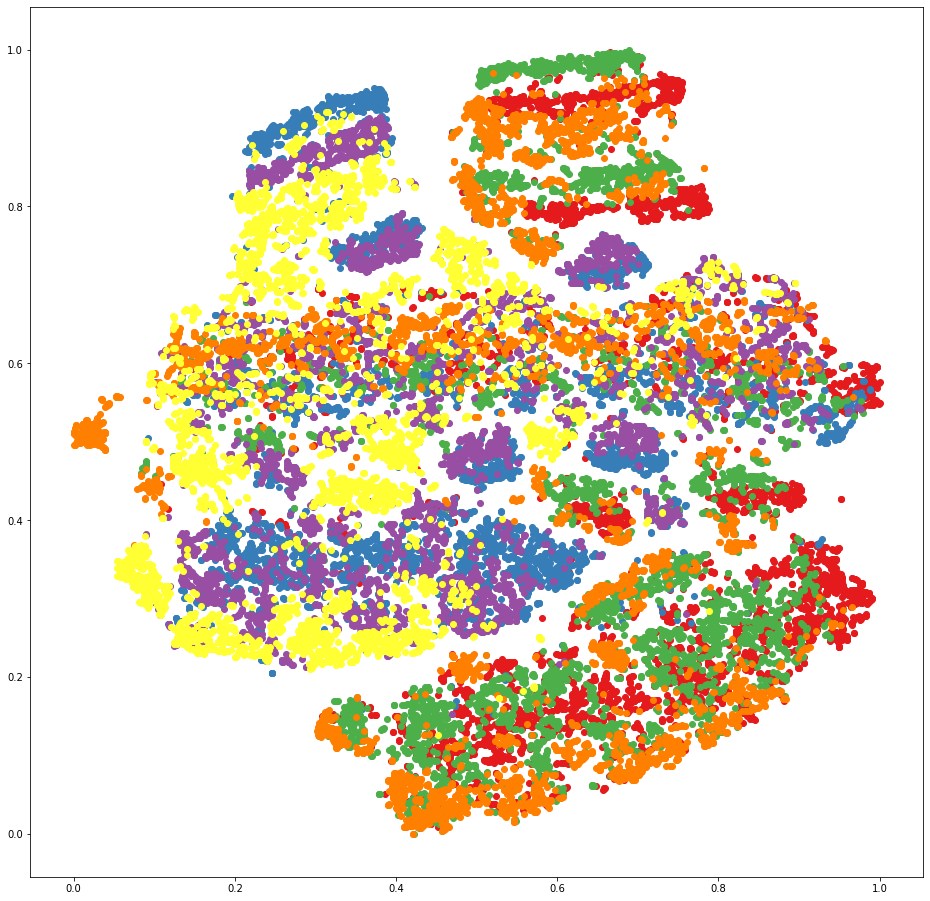

In [44]:
plot(X_tsne, y)

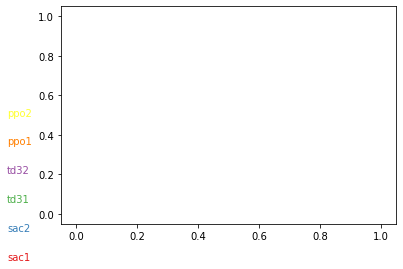

In [51]:
names = ['sac1', 'sac2', 'td31', 'td32', 'ppo1', 'ppo2']
f = plt.figure(1)
for i in range(len(names)):
    f.text(0,0.1*i, names[i], color = plt.cm.Set1(i))
plt.plot()
plt.show()

In [52]:
def get_data2(ts):
    ret = []
    for t in ts:
        for i in range(100, 200):
            if len(t) > i:
                ret.append(t[i].qpos)
    return ret
sac_d1 = get_data2(sac_t1)
sac_d2 = get_data2(sac_t2)
td3_d1 = get_data2(td3_t1)
td3_d2 = get_data2(td3_t2)
ppo_d1 = get_data2(ppo_t1)
ppo_d2 = get_data2(ppo_t2)
x = sac_d1 + sac_d2 + td3_d1 + td3_d2 + ppo_d1 + ppo_d2
y = [0] * len(sac_d1) + [1] * len(sac_d2) + [2] * len(td3_d1) + [3] * len(td3_d2) + [4] * len(ppo_d1) + [5] * len(ppo_d2)
tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(x)

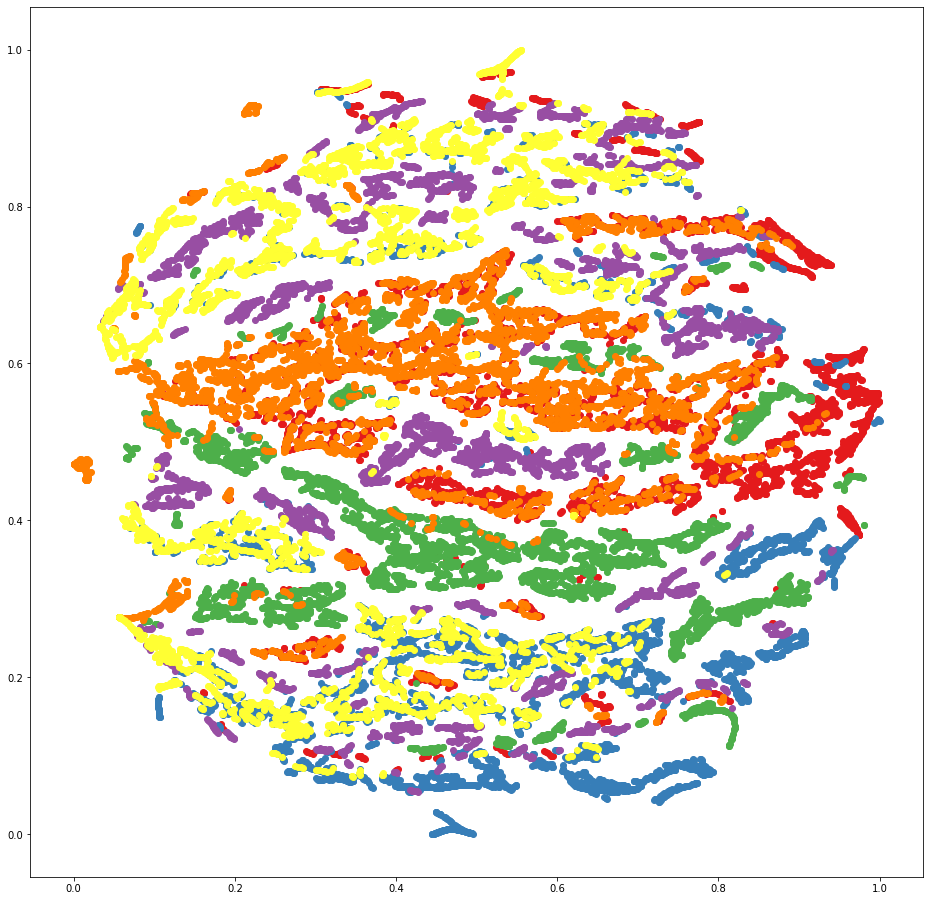

In [53]:
plot(X_tsne, y)

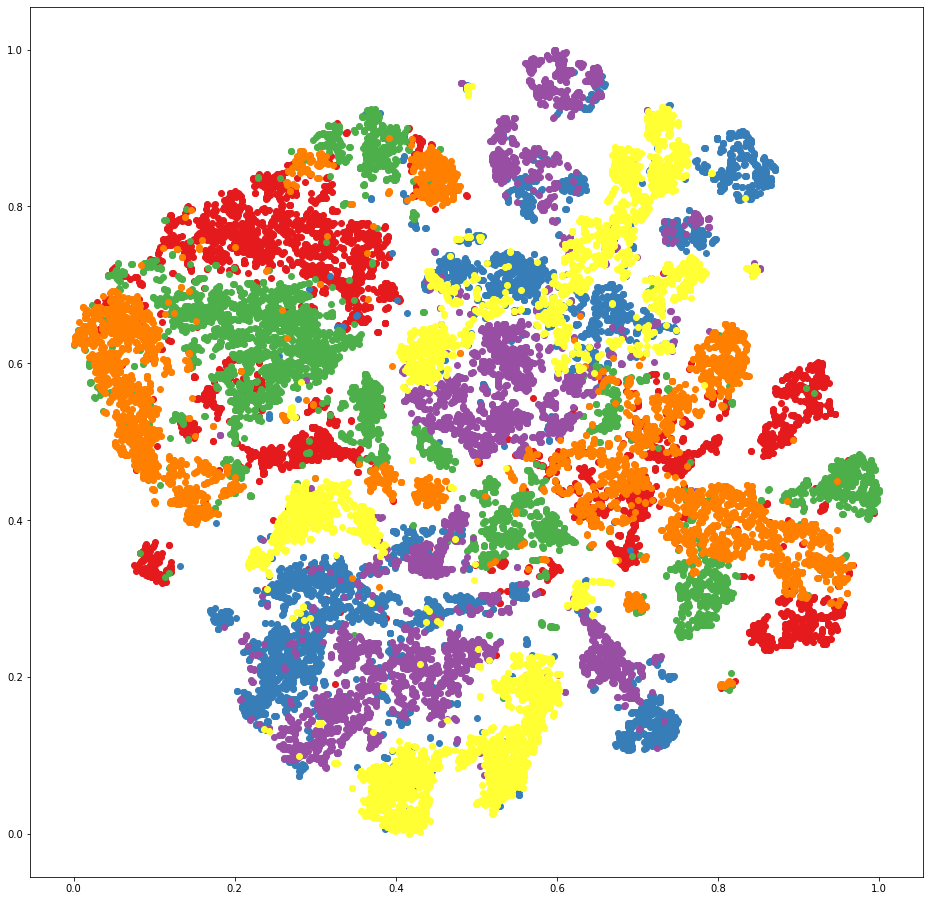

In [54]:
def get_data3(ts):
    ret = []
    for t in ts:
        for i in range(100, 200):
            if len(t) > i:
                o = restore_state(env, t[i])
                ret.append(o)
    return ret
sac_d1 = get_data3(sac_t1)
sac_d2 = get_data3(sac_t2)
td3_d1 = get_data3(td3_t1)
td3_d2 = get_data3(td3_t2)
ppo_d1 = get_data3(ppo_t1)
ppo_d2 = get_data3(ppo_t2)
x = sac_d1 + sac_d2 + td3_d1 + td3_d2 + ppo_d1 + ppo_d2
y = [0] * len(sac_d1) + [1] * len(sac_d2) + [2] * len(td3_d1) + [3] * len(td3_d2) + [4] * len(ppo_d1) + [5] * len(ppo_d2)
tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(x)
plot(X_tsne, y)


In [8]:
def get_data3(ts):
    ret = []
    for t in ts:
        for i in range(100, 200):
            if len(t) > i:
                o = restore_state(env, t[i])
                ret.append(o)
    return ret
sac_d1 = get_data3(sac_t1)
sac_d2 = get_data3(sac_t2)
td3_d1 = get_data3(td3_t1)
td3_d2 = get_data3(td3_t2)
ppo_d1 = get_data3(ppo_t1)
ppo_d2 = get_data3(ppo_t2)
x = sac_d1 + sac_d2 
y = [0,1] * int(len(sac_d1)/2) + [2,3] * int(len(sac_d2)/2)
tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(x)
plot(X_tsne, y)

NameError: name 'sac_t1' is not defined

In [7]:
x = True
print(float(x))

1.0


In [13]:
import random
random.random()

0.1881743551177243

In [7]:
import numpy as np
x = [199, 1, 231, 1243, 2]
y = np.argsort(x)
print(y)

[1 4 0 2 3]


In [9]:
for i in range(1, 10):
    print(i)

1
2
3
4
5
6
7
8
9


In [14]:
import random
random.sample(range(10), 4)

[2, 7, 0, 9]

In [1]:
for i in range(101, 102):
    print(i)

101
